# Quick Start Guide
This notebook demonstrates the core functionality of the BioNeuralNet package. It covers data loading, network generation, network embedding via GNNs, subject representation, downstream disease prediction, evaluation metrics, clustering, and use of external tools."

## Load Demo Dataset

- BioNeuralNet includes built-in demo datasets via `DatasetLoader`, allowing you to explore and test the framework without preparing your own data.
- Each omics dataset includes 358 samples, pre-aligned across phenotype and clinical data.
- This setup is useful for quickly testing the full BioNeuralNet pipeline, from preprocessing and graph construction to model training and evaluation.


In [3]:
import pandas as pd
from bioneuralnet.datasets import DatasetLoader

Example = DatasetLoader("example")
omics1 = Example.data["X1"]
omics2= Example.data["X2"]
phenotype = Example.data["Y"]
clinical = Example.data["clinical_data"]

In [4]:
print(omics1)
print(omics2)
print(phenotype)
print(clinical)

             Gene_1     Gene_2  ...   Gene_499   Gene_500
Samp_1    22.485701  40.353720  ...  13.400950  12.769172
Samp_2    37.058850  34.052233  ...  12.066379  12.583460
Samp_3    20.530767  31.669623  ...  12.891962  12.760553
Samp_4    33.186888  38.480880  ...  12.810732  12.972879
Samp_5    28.961981  41.060494  ...  12.479124  12.156407
...             ...        ...  ...        ...        ...
Samp_354  24.520652  28.595409  ...  13.644383  13.018032
Samp_355  31.252789  28.988087  ...  12.947672  13.161434
Samp_356  24.894826  25.944887  ...  12.129990  13.844271
Samp_357  17.034337  38.574705  ...  12.943670  13.996352
Samp_358  20.839167  27.099788  ...  13.257230  13.178058

[358 rows x 500 columns]
              Mir_1      Mir_2  ...     Mir_99    Mir_100
Samp_1    15.223913  17.545826  ...  11.422531  10.862970
Samp_2    16.306965  16.672830  ...  12.413667  10.719110
Samp_3    16.545119  16.735005  ...  11.072915  11.418794
Samp_4    13.986899  16.207432  ...  10.121957

## Constructing a Multi-omics Network

BioNeuralNet supports a variety of graph construction techniques to model relationships between biological features. These graphs serve as the foundation for applying Graph Neural Networks in downstream tasks. using the following functions users can convert a multi-omics dataset (subjects in rows, features in columns) into a multi-omics network.

To see more network construction examples, including visulizations, visit the [Network Construction Guide](https://bioneuralnet.readthedocs.io/en/latest/network_construction.html).

Supported graph types include:

- **Cosine similarity**
- **Pearson or Spearman correlation**
- **Soft-thresholding (WGCNA-style)**
- **Gaussian k-NN**
- **Minimum Spanning Tree (MST)**
- **Shared Nearest Neighbor (SNN)**

Each method is available through the `utils.graph` module.
Additional details can be found in the [utils documentation](https://bioneuralnet.readthedocs.io/en/latest/utils.html).

## Example 1: SmCCNet 2.0

In this section, we'll construct a multi-omics networks using **SmCCNet 2.0**, an R-based method.

A Python wrapper is available under `bioneuralnet.external_tools.smccnet` to streamline usage. This requires R and the SmCCNet package.

For setup instructions and usage examples, see the [external tools guide](https://bioneuralnet.readthedocs.io/en/latest/external_tools/index.html).

**Resources**

* CRAN: [SmCCNet on CRAN](https://cran.r-project.org/web/packages/SmCCNet/)
* GitHub: [KechrisLab/SmCCNet](https://github.com/KechrisLab/SmCCNet)
* Paper: [BMC Bioinformatics (2024)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-024-05900-9)


In [ ]:
from bioneuralnet.external_tools import SmCCNet

smccnet = SmCCNet(
    phenotype_df=phenotype,
    omics_dfs=[omics1, omics2],
    data_types=["genes", "mirna"],
    subSampNum=1000,
)
global_network, clusters = smccnet.run()

In [6]:
print("Global network shape:", global_network.shape)
print("Number of SmCCnet clusters:", len(clusters))
print(global_network.head())

Global network shape: (600, 600)
Number of SmCCnet clusters: 3
          Gene_1    Gene_2  ...  Mir_99  Mir_100
Gene_1  0.000000  0.158521  ...       0        0
Gene_2  0.158521  0.000000  ...       0        0
Gene_3  0.000000  0.000000  ...       0        0
Gene_4  0.000000  0.000000  ...       0        0
Gene_5  0.039205  0.035508  ...       0        0

[5 rows x 600 columns]


## Example 2: Similarity Graph

Build a normalized k-nearest neighbors (kNN) similarity graph from feature vectors.  

The function computes pairwise `cosine` or `Euclidean` distances, sparsifies the matrix by keeping `top-k` neighbours per node (or by applying a globalthreshold), optionally prunes edges to mutual neighbours, and can add self-loops.

**Args**:
- **X** (`pd.DataFrame`): Dataframe of shape **(N, D)** where:
    - **N** (`rows`): number of subjects/samples.
    - **D** (`columns`): omics features.
- **k** (`int`): Number of neighbors to keep per node.
- **metric** (`str`): `cosine` or `Euclidean` (uses gaussian kernel on distances).  
- **mutual** (`bool`): If `True`, retain only mutual edges (i->j and j->i).
- **per_node** (`bool`): If `True`, use per-node `k`, else apply a global cutoff.  
- **self_loops** (`bool`): If `True`, add a self-loop weight of 1.  

**Returns**:
- A `pd.DataFrame` of shape (D, D) the normalized multi-omics network.

In [ ]:
from bioneuralnet.utils.graph import gen_similarity_graph

X_train_full = pd.concat([omics1, omics2], axis=1)
A_train = gen_similarity_graph(X_train_full, k=15)

## GNN-Based Network Embedding

Once a graph has been constructed, BioNeuralNet enables low-dimensional embedding of omics data using the `GNNEmbedding` module. This component applies Graph Neural Networks (e.g., GCN or GAT) to integrate omics, clinical, and phenotype data into a unified graph framework.

The output is a compact embedding for each subject that captures both feature and network structure, ideal for downstream tasks like classification, clustering, or visualization.

To use:

1. Concatenate omics datasets into a single feature matrix
2. Provide the graph and metadata to `GNNEmbedding`
3. Call `.fit()` to train the model and `.embed()` to extract embeddings as a DataFrame

These embeddings form the foundation for advanced machine learning on complex biological systems.


In [ ]:
from bioneuralnet.network_embedding import GNNEmbedding

merged_omics = pd.concat([omics1, omics2], axis=1)

gnn = GNNEmbedding(
    adjacency_matrix=global_network,
    omics_data=merged_omics,
    phenotype_data=phenotype,
    clinical_data=clinical,
    phenotype_col="phenotype",
    tune=True,
    gpu=True,
)
gnn.fit()
embeddings = gnn.embed(as_df=True)

In [8]:
print(embeddings.head())

         Embed_1   Embed_2  ...  Embed_15  Embed_16
Gene_1  2.291541 -0.006752  ...  0.865972  1.384877
Gene_2  1.301154 -0.011410  ...  1.459566  1.621363
Gene_3  0.004610  0.534755  ...  0.156256  0.479289
Gene_4  0.158565 -0.005850  ...  0.611468  0.844665
Gene_5  0.323387 -0.003033  ...  0.789242  1.205275

[5 rows x 16 columns]


## Embeddings visualization

We projected the 16‑dimensional node embeddings into 2‑D and observed three clear regions plus one broad cloud.
The class buckets (after binning the continuous phenotype into four equal‑frequency groups) contain:

| Group  | Samples |
| ------ | ------- |
| 0      | 38      |
| 1      | 158     |
| 2      | 141     |
| 3      | 21      |

**Visual observations**

- **Middle‑left cloud**

    - Largest and most diffuse region
    - Contains the majority of points
    - Most likely accounting for group 1 and 2

- **Top‑right hand oval**

    - Compact cluster on the far right
    - Roughly forty points
    - Could be group 0 or 3

- **Lower-right hand cluster**

    - Compact group far below the main cloud
    - Also around forty points
    - Could be group 0 or 3


In [9]:
from bioneuralnet.metrics import plot_embeddings

# Using our embeddings instance we get the necessary labels for the graph.
node_labels = gnn._prepare_node_labels()
embeddings_array = embeddings.values  

2025-05-27 12:27:04,683 - bioneuralnet.network_embedding.gnn_embedding - INFO - Preparing node labels.
2025-05-27 12:27:04,736 - bioneuralnet.network_embedding.gnn_embedding - INFO - Node labels prepared successfully and saved to /tmp/tmpd6libqyo/labels_600_0527_12_27_04.txt.


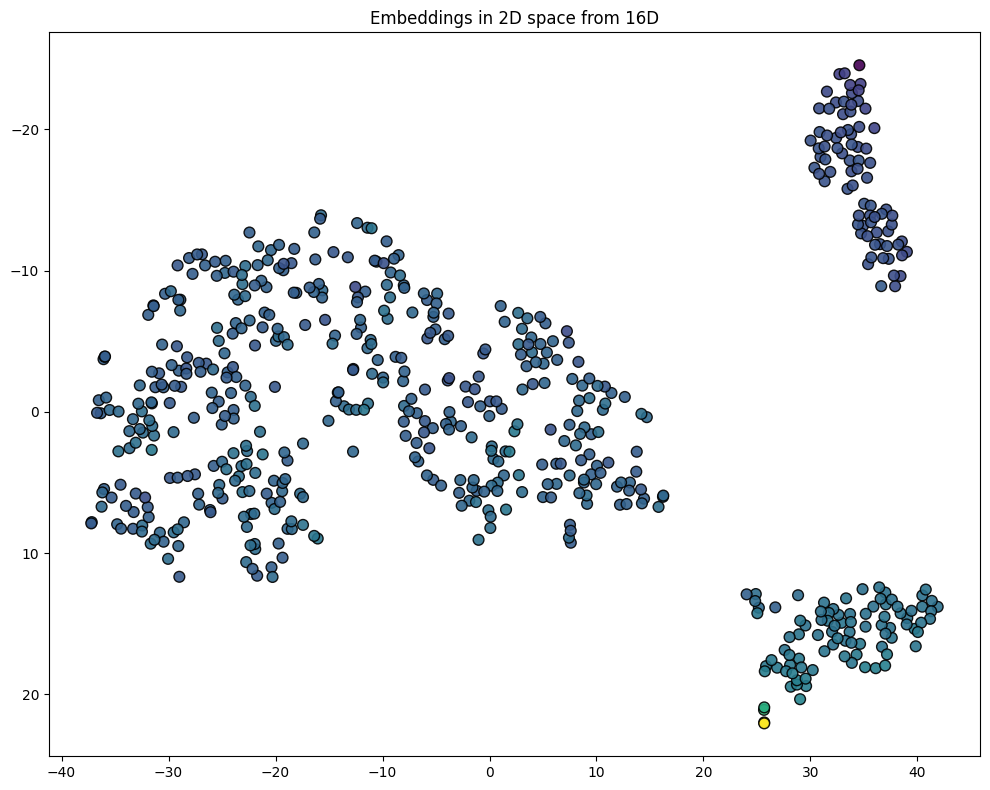

In [10]:
embeddings_plot = plot_embeddings(embeddings_array, node_labels)

## Subject Representation

We enrich the original omics data by combining it with our 16D graph-based embeddings.

- `SubjectRepresentation` merges embeddings, omics, and phenotype data.
- This produces a compact, information-rich input for modeling.
- For details, see [GNN Embeddings for Multi-Omics](https://bioneuralnet.readthedocs.io/en/latest/gnns.html).

In [ ]:
from bioneuralnet.downstream_task import SubjectRepresentation

graph_embed = SubjectRepresentation(
    omics_data=merged_omics,
    embeddings=embeddings,
    phenotype_data=phenotype,
    phenotype_col="phenotype",
    tune=True,
)
enhanced_omics = graph_embed.run()

In [12]:
print("Before graph embedding:")
print(merged_omics.head())

Before graph embedding:
           Gene_1     Gene_2  ...     Mir_99    Mir_100
Samp_1  22.485701  40.353720  ...  11.422531  10.862970
Samp_2  37.058850  34.052233  ...  12.413667  10.719110
Samp_3  20.530767  31.669623  ...  11.072915  11.418794
Samp_4  33.186888  38.480880  ...  10.121957  11.039089
Samp_5  28.961981  41.060494  ...  12.206151  10.724849

[5 rows x 600 columns]


In [13]:
print("After graph embedding:")
print(enhanced_omics.head())

After graph embedding:
           Gene_1     Gene_2  ...     Mir_99   Mir_100
Samp_1  30.124834  51.637941  ...  14.502229 -4.488456
Samp_2  49.648960  43.574352  ...  15.760591 -4.429015
Samp_3  27.505743  40.525486  ...  14.058350 -4.718116
Samp_4  44.461565  49.241394  ...  12.850998 -4.561226
Samp_5  38.801318  52.542352  ...  15.497125 -4.431386

[5 rows x 600 columns]


## Disease Classification with DPMON

DPMON extends the GNN pipeline for multi-class disease prediction by:

- Fusing omics features with graph-derived node embeddings
- Applying a classification head (e.g., softmax + cross-entropy) for phenotype prediction
- Supporting full end-to-end training.

In this example, we discretize the continuous phenotype into 4 equally populated classes using `pd.cut`, enabling multi-class classification.

In [14]:
from bioneuralnet.datasets import DatasetLoader
import numpy as np

Example = DatasetLoader("example")
omics1 = Example.data["X1"]
omics2 = Example.data["X2"]
phenotype = Example.data["Y"]
clinical = Example.data["clinical_data"]

min_val = phenotype["phenotype"].min()
max_val = phenotype["phenotype"].max()

# linspace creates an array of evenly spaced values
bins = np.linspace(min_val, max_val, 5)

phenotype["phenotype"] = pd.cut(phenotype["phenotype"], bins=bins, labels=[0, 1, 2, 3], include_lowest=True)
count_values = phenotype["phenotype"].value_counts(sort=False)

In [15]:
# After binning
print(phenotype)
print(count_values)

         phenotype
Samp_1           1
Samp_2           2
Samp_3           1
Samp_4           3
Samp_5           2
...            ...
Samp_354         1
Samp_355         1
Samp_356         2
Samp_357         1
Samp_358         1

[358 rows x 1 columns]
phenotype
0     38
1    158
2    141
3     21
Name: count, dtype: int64


## DPMON Evaluation Example

In this example, we evaluate **DPMON** over 3 independent runs to assess classification performance.

For each run:

- A new `DPMON` instance is initialized with the same omics, phenotype, clinical data, and global network.
- `repeat_num = 3` runs internal training three times with different seeds.
- We call `.run()` to generate predictions and extract:

  - **Accuracy**
  - **F1 (Weighted)**
  - **F1 (Macro)**

Afterward, we compute the mean and standard deviation of each metric to enable fair comparison with other models like Random Forest, using consistent evaluation across runs.

In [ ]:
from bioneuralnet.downstream_task import DPMON
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

acc_scores = []
f1w_scores = []
f1m_scores = []

for i in range(3):
    print(f"DPMON run {i+1}")
    
    dpmon = DPMON(
        adjacency_matrix=global_network,
        omics_list=[omics1, omics2],
        phenotype_data=phenotype,
        clinical_data=clinical,
        repeat_num=5,
        tune=True,
        gpu=True,
        cuda=0,
        output_dir="dpmon_output"
    )
    
    predictions_df = dpmon.run()
    y_true = predictions_df[0]["Actual"]
    y_pred = predictions_df[0]["Predicted"]

    acc = accuracy_score(y_true, y_pred)
    f1w = f1_score(y_true, y_pred, average="weighted")
    f1m = f1_score(y_true, y_pred, average="macro")

    acc_scores.append(acc)
    f1w_scores.append(f1w)
    f1m_scores.append(f1m)

# get the mean and std in tuple form
dpmon_acc_tuple = (np.mean(acc_scores), np.std(acc_scores))
dpmon_f1w_tuple = (np.mean(f1w_scores), np.std(f1w_scores))
dpmon_f1m_tuple = (np.mean(f1m_scores), np.std(f1m_scores))


## Performance Comparison

We compare **DPMON** to a baseline Random Forest using raw omics data across 5 runs.

- Metrics: **Accuracy**, **F1-Weighted**, **F1-Macro**
- Bars show mean performance, error bars indicate standard deviation

DPMON consistently outperforms the baseline across all metrics.

2025-05-27 12:41:52,230 - bioneuralnet.metrics.plot - INFO - Plotting multiple metrics: ['Accuracy', 'F1-Weighted', 'F1-Macro']


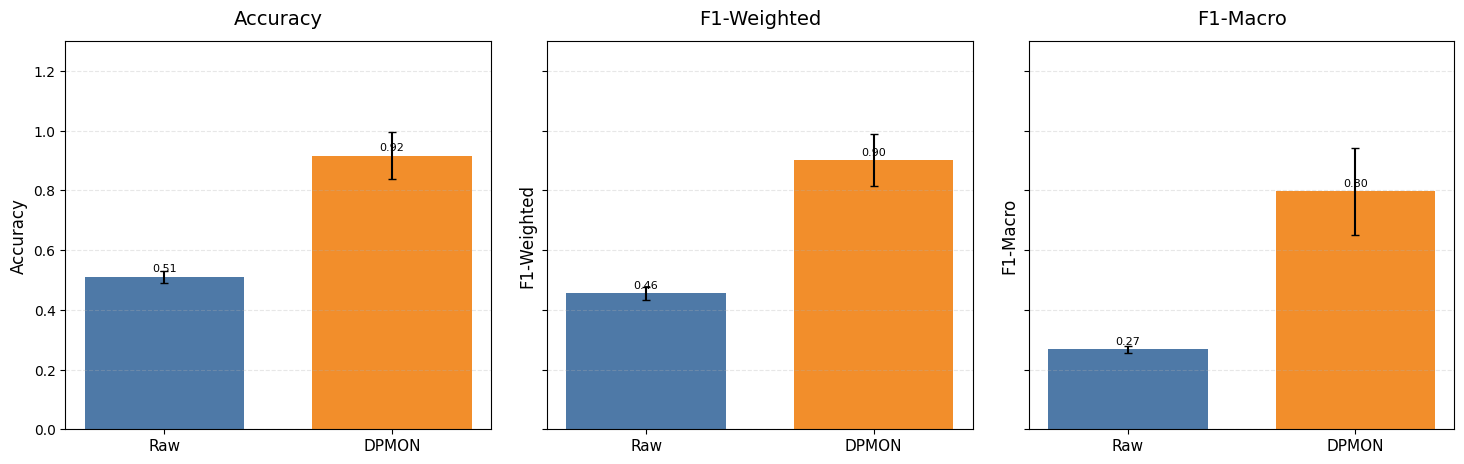

In [24]:
from bioneuralnet.metrics import evaluate_rf, plot_multiple_metrics

# raw omics evaluation
X_raw = merged_omics.values
y_global = phenotype.values
rf_acc, rd_f1w, rf_f1m = evaluate_rf(X_raw, y_global, n_estimators=100, runs=5, mode="classification")

# metrics dictionary
metrics = {
    "Accuracy": {"Raw": rf_acc,"DPMON": dpmon_acc_tuple},
    "F1-Weighted": {"Raw": rd_f1w,"DPMON": dpmon_f1w_tuple},
    "F1-Macro": {"Raw": rf_f1m, "DPMON": dpmon_f1m_tuple}
}

plot_multiple_metrics(metrics)

## Phenotype-Aware Clustering

BioNeuralNet includes phenotype-guided clustering tools like **HybridLouvain**, which extend standard graph methods (e.g., Louvain) to incorporate phenotype correlation. This allows detection of biologically meaningful modules.

- Accepts any network and omics matrix as input
- Optimizes modularity while aligning clusters to phenotype signal
- Can be compared with external clustering (e.g., SmCCNet)

For details, see the [Correlated Clustering documentation](https://bioneuralnet.readthedocs.io/en/latest/clustering.html).

In [ ]:
from bioneuralnet.clustering import  HybridLouvain
import networkx as nx

merged_omics = pd.concat([omics1, omics2], axis=1)
G_network = nx.from_pandas_adjacency(global_network)

hybrid = HybridLouvain(
    G=G_network,
    B=merged_omics,
    Y=phenotype,
    tune=True,
)
hybrid_result = hybrid.run(as_dfs=True)

Number of clusters: 2


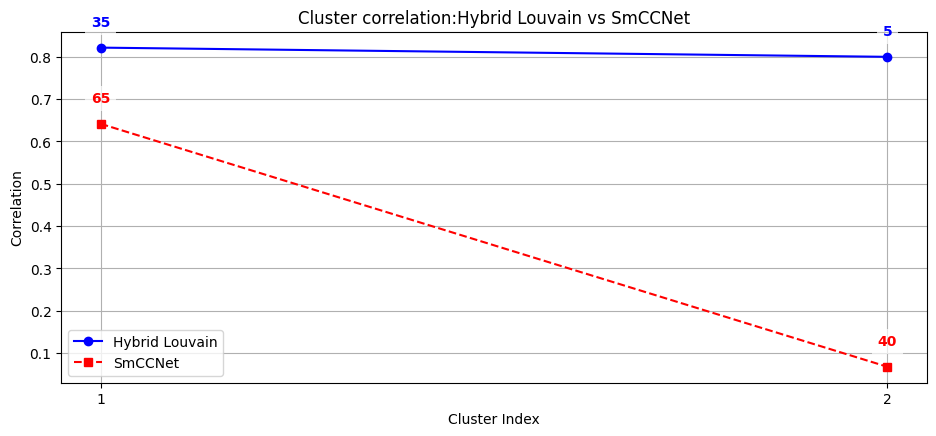

,Cluster,Louvain Size,Louvain Correlation,SMCCNET Size,SMCCNET Correlation
0,Cluster_1,35,0.821929,65,0.641804
1,Cluster_2,5,0.800173,40,0.067307


In [19]:
# Lets compare hytbrid louvain with the SmCCNet clusters
print("Number of clusters:", len(hybrid_result))

compare_clusters(hybrid_result, clusters, phenotype, merged_omics)

## Network Visualization

BioNeuralNet supports flexible visualization of omics networks, including but not limited to clustering results like Hybrid Louvain.

You can:

- Visualize **any adjacency matrix** or feature-level graph
- **Toggle node labels** and **edge weights** to suit your analysis
- Apply a **threshold** to filter weaker edges and focus on key structure

This makes it easy to explore network topology, inspect connectivity patterns, and interpret biological relationships across genes, samples, or other entities.

For details, see the [documentation](https://bioneuralnet.readthedocs.io/en/latest/metrics.html).

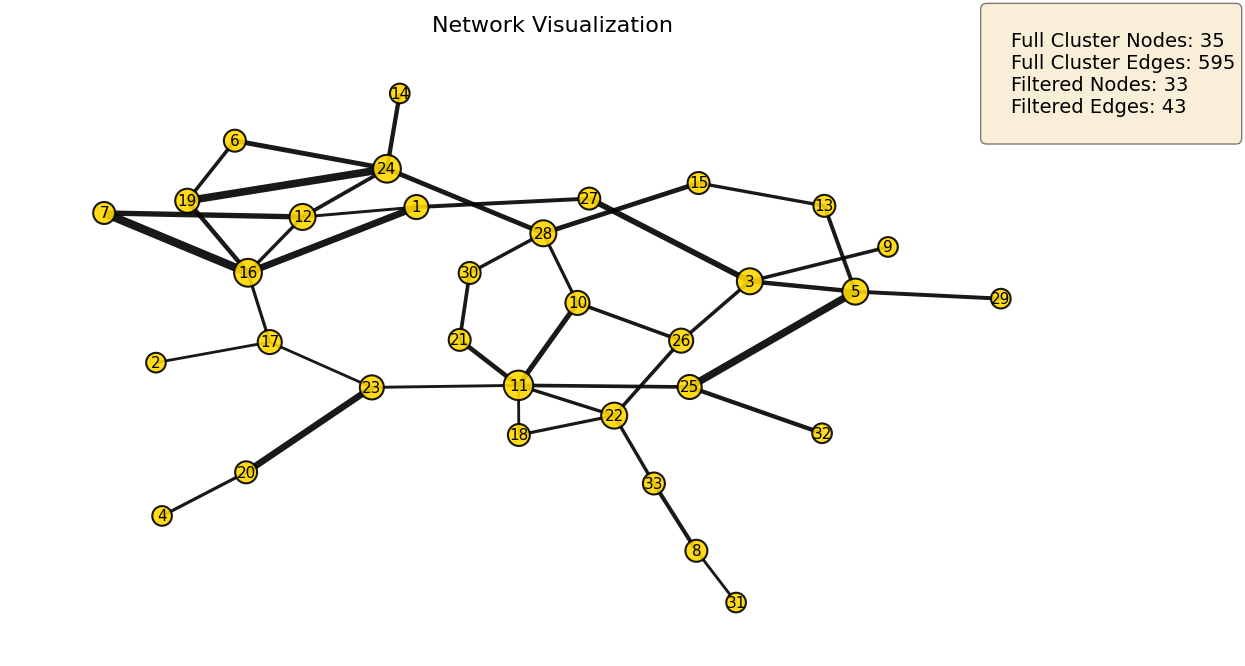

           Omic  Degree
Index                  
11     Gene_411       6
16       Gene_7       5
24     Gene_174       5
3        Gene_1       4
28     Gene_114       4


In [20]:
from bioneuralnet.metrics import plot_network
from bioneuralnet.metrics import louvain_to_adjacency

cluster1 = hybrid_result[0]
cluster2 = hybrid_result[1]

# Convert Louvain clusters into adjacency matrices
louvain_adj1 = louvain_to_adjacency(cluster1)
louvain_adj2 = louvain_to_adjacency(cluster2)

# Plot using the converted adjacency matrices

cluster1_mapping = plot_network(louvain_adj1, weight_threshold=0.1, show_labels=True, show_edge_weights=False)
print(cluster1_mapping.head())

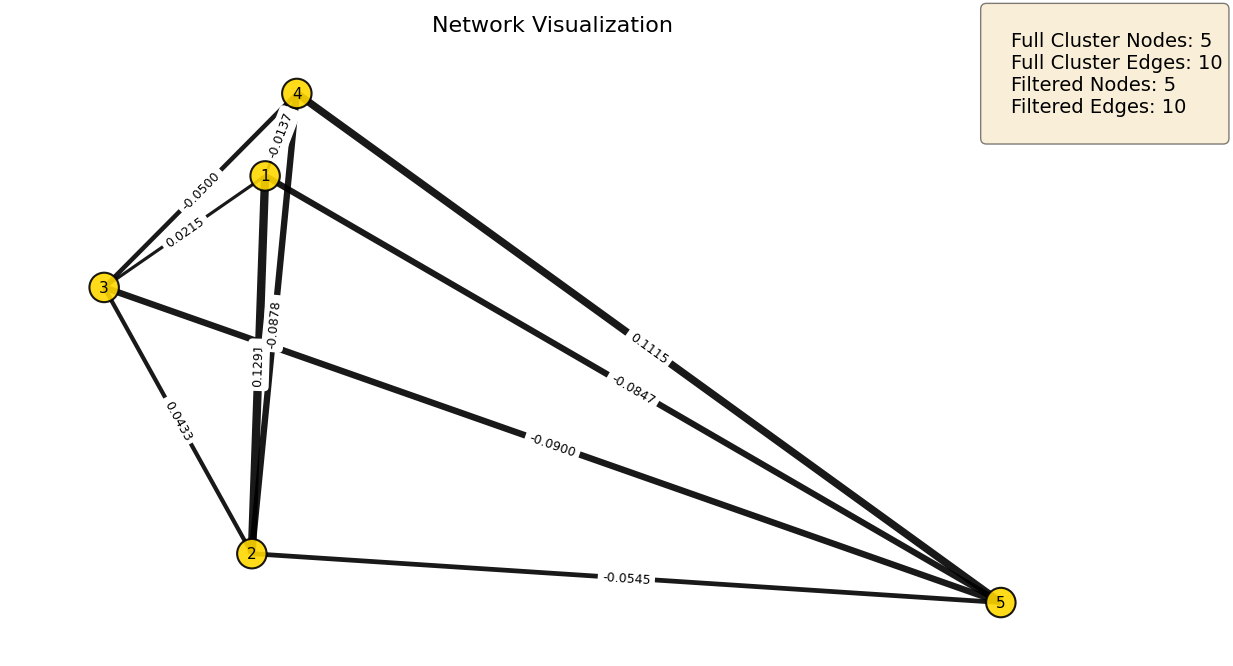

           Omic  Degree
Index                  
1        Gene_7       4
2        Gene_6       4
3        Gene_1       4
4      Gene_446       4
5       Gene_53       4


In [21]:
cluster2_mapping = plot_network(louvain_adj2, weight_threshold=0.01, show_labels=True, show_edge_weights=True)
print(cluster2_mapping.head())

In [ ]:
import bioneuralnet
print(f"BioNeuralNet version: {bioneuralnet.__version__}")

BioNeuralNet version: 1.1.3
